# Task 2 — Bayesian Change Point Model

Single change point model on log returns with PyMC.

In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm

ROOT = Path('..').resolve()
sys.path.append(str(ROOT))

from src.data_preprocessing import load_brent_data, calculate_returns, load_events_data
from src.bayesian_model import build_single_changepoint_model

df = load_brent_data(str(ROOT / 'data' / 'raw' / 'BrentOilPrices.csv'))
df_r = calculate_returns(df)
data = df_r['Log_Returns'].values
dates = df_r['Date'].values

events = load_events_data(str(ROOT / 'data' / 'events' / 'key_events.csv'))
events.head()

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


,Date,Event_Title,Region_Country,Event_Type,Short_Description
0,1990-08-02,Iraqi Invasion of Kuwait,Iraq/Kuwait,Conflict/Geopolitical,"Iraqi invasion triggers 1990 oil price shock, ..."
1,1991-01-16,Gulf War Begins,Iraq/Coalition,Conflict,U.S-led forces push Iraq out of Kuwait; initia...
2,1997-07-01,Asian Financial Crisis,Asia,Economic Crisis,Regional financial crisis weakens global deman...
3,1998-01-01,Oil Price Collapse (1998),Global,Demand Shock,Oversupply and Asian crisis push oil prices to...
4,2000-01-01,Dot-Com Slowdown Impact,Global,Economic Slowdown,Slowing global growth softens oil demand and p...


In [2]:
# Build model
model = build_single_changepoint_model(data)

with model:
    trace = pm.sample(1000, tune=1000, chains=2, cores=1, target_accept=0.9, random_seed=42)

az.summary(trace)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2, sigma1, sigma2]


<div><progress max="2000" value="2000"></progress> 100.00% [2000/2000 00:50&lt;00:00... Sampling chain 0, 0 divergences]</div>

<div><progress max="2000" value="2000"></progress> 100.00% [2000/2000 01:01&lt;00:00... Sampling chain 1, 0 divergences]</div>

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 113 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,4796.208,587.252,4201.000,5406.000,413.461,349.722,3.0,33.0,1.86
mu1,0.000,0.000,-0.000,0.001,0.000,0.000,19.0,756.0,1.07
mu2,-0.001,0.001,-0.002,0.000,0.000,0.000,6.0,107.0,1.23
sigma1,0.023,0.000,0.023,0.024,0.000,0.000,3.0,64.0,1.73
sigma2,0.027,0.001,0.026,0.028,0.001,0.001,3.0,65.0,1.83


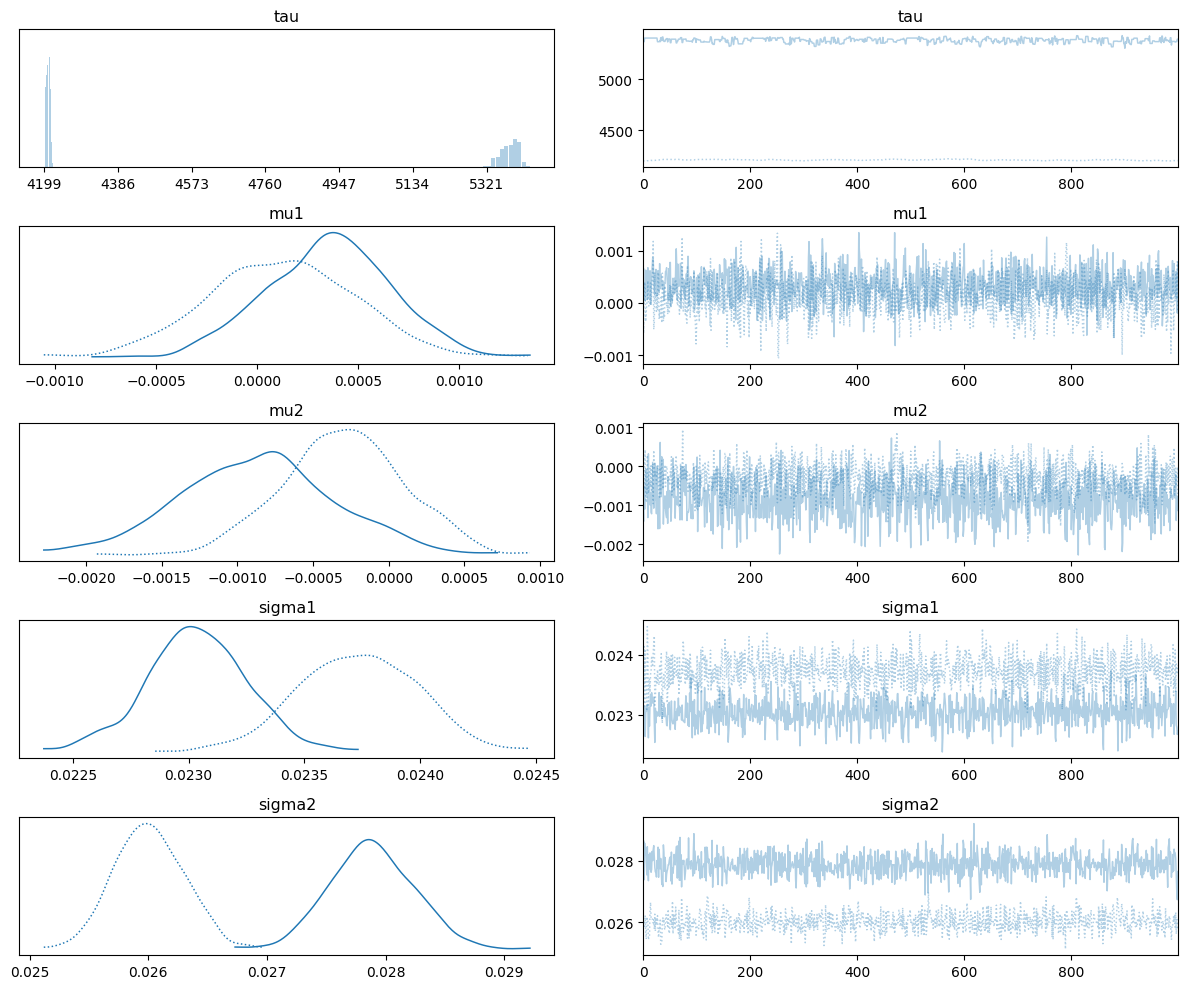

In [3]:
# Convergence & trace plots
az.plot_trace(trace, var_names=['tau', 'mu1', 'mu2', 'sigma1', 'sigma2'])
plt.tight_layout()

Timestamp('2006-03-22 00:00:00')

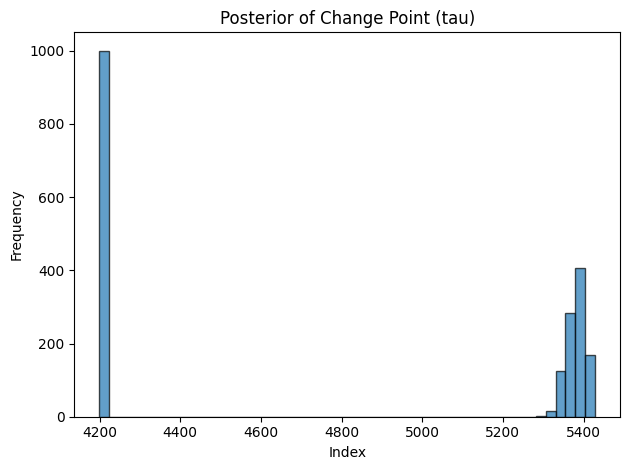

In [4]:
# Change point posterior
tau_samples = trace.posterior['tau'].values.flatten()
plt.hist(tau_samples, bins=50, edgecolor='black', alpha=0.7)
plt.title('Posterior of Change Point (tau)')
plt.xlabel('Index')
plt.ylabel('Frequency')
plt.tight_layout()

tau_mean = int(np.mean(tau_samples))
cp_date = pd.to_datetime(dates[tau_mean])
cp_date

In [5]:
# Quantify impact
mu1 = trace.posterior['mu1'].values.flatten()
mu2 = trace.posterior['mu2'].values.flatten()

impact = {
    'mu1_mean': float(mu1.mean()),
    'mu2_mean': float(mu2.mean()),
    'delta': float(mu2.mean() - mu1.mean()),
}
impact

{'mu1_mean': 0.0002367316793876833,
 'mu2_mean': -0.0005855924775702384,
 'delta': -0.0008223241569579216}

In [6]:
# Associate change point with events (nearest by date)
events['days_diff'] = (events['Date'] - cp_date).abs().dt.days
events.sort_values('days_diff').head(5)

,Date,Event_Title,Region_Country,Event_Type,Short_Description,days_diff
7,2005-08-29,Hurricane Katrina Disrupts U.S. Oil,U.S.,Weather/Production Disruption,Major Gulf production shutdown boosts oil prices.,205
8,2007-08-01,Financial Crisis Begins,Global,Financial Crisis,Early signs of global credit crunch weaken dem...,497
9,2008-07-01,Oil Hits Record High ~$147,Global,Demand/Supply Shock,Strong global growth and constrained supply pu...,832
10,2008-09-15,Lehman Brothers Collapse,U.S./Global,Financial Crisis,Oil prices crash as recession fears and demand...,908
6,2003-03-20,Iraq War Begins,Iraq/Global,Conflict,Invasion raises risk premium on oil supply.,1098
